### Forecast Energy Consumption
In this notebook we are going to do Energy Consumption focusting using the `XGBoost` algorithm. The dataset that we are going to use was obtained on kaggle at this url:

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/input

### Common Time Series Partens

<p align="center"><img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg" alt="ts" width="80%"/></p>

1. **Trend Component**- 
The long-term tendency of a series to increase or fall (upward trend or downward trend)


**2. Seasonality Compon**e- t

The periodic fluctuation in the time series within a certain period. These fluctuations form a pattern that tends to repeat from one seasonal period to the next ne.**

3. Cycles Co**m- onent

Long departures from the trend due to factors others than seasonality. Cycles usually occur along a large time interval, and the lengths of time between successive peaks or troughs of a cycle are not necessarily te s**ame.

4. Irregular movemen**t- Component

The movement left after explaining the trend, seasonal and cyclical movements; random noise or error in a time series.

### Imports

In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgb.__version__

'2.1.2'

### Data

For the data we are going to use the `AEP_hourly.csv` file for this task.

In [59]:
dataframe = pd.read_csv('./PJME_hourly.csv')
dataframe = dataframe.set_index('Datetime')
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.head(2)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0


Let's plot the data that we have.

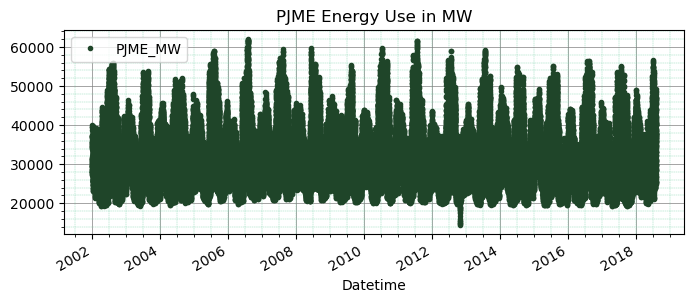

In [61]:
dataframe.plot(style='.', figsize=(8, 3),color="#1F4529", title='PJME Energy Use in MW')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to split our dataset, we are going take the data from the `1st` of January to the end of 2018 to be the data in the test set, and the rest will remain for the training set.

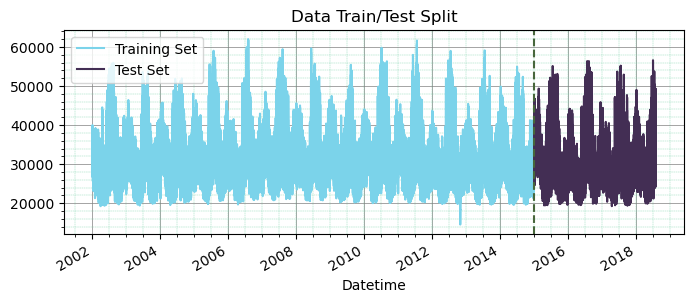

In [63]:
train = dataframe.loc[dataframe.index < '01-01-2015']
test = dataframe.loc[dataframe.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(8, 3))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color="#7BD3EA")
test.plot(ax=ax, label='Test Set', color="#432E54")
ax.axvline('01-01-2015', color='#47663B', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Let's plot the weekly data from `1rst` of `January 2016`.

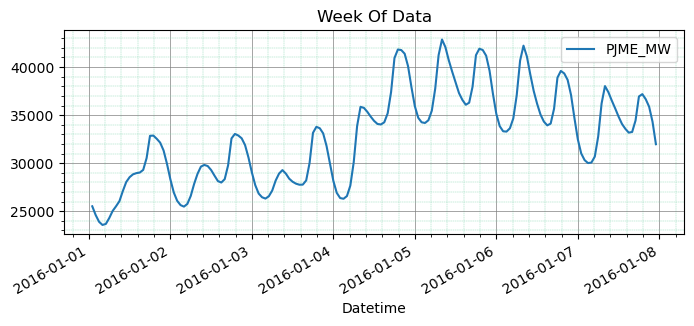

In [66]:
dataframe.loc[(dataframe.index > '01-01-2016') & (dataframe.index < '01-08-2016')].plot(figsize=(8, 3), title='Week Of Data')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Feature Creation
In the following code cell we are going to look at creating features. For that we are going to create a function that will do that called `create_features`.

In [68]:
def create_features(dataframe):
    """
    Create time series features based on time series index.
    """
    dataframe = dataframe.copy()
    dataframe['hour'] = dataframe.index.hour
    dataframe['dayofweek'] = dataframe.index.dayofweek
    dataframe['quarter'] = dataframe.index.quarter
    dataframe['month'] = dataframe.index.month
    dataframe['year'] = dataframe.index.year
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['dayofmonth'] = dataframe.index.day
    dataframe['weekofyear'] = dataframe.index.isocalendar().week
    return dataframe

dataframe = create_features(dataframe)
dataframe.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1


Let's visualize the relationships between our features and labels. We are going to use the `BoxPlot`

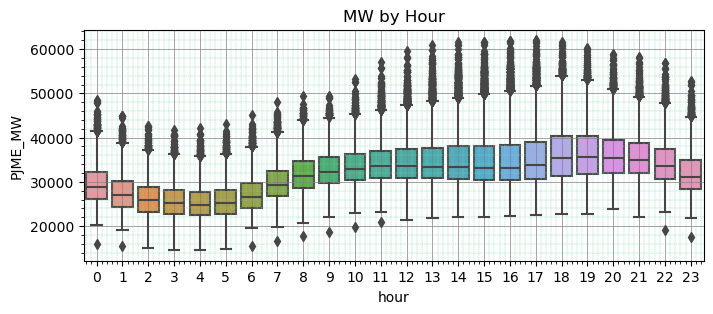

In [70]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=dataframe, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

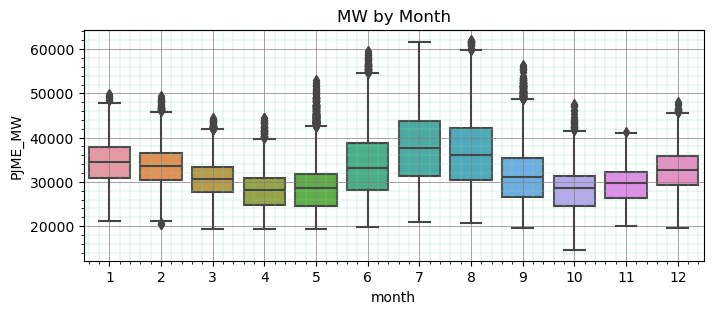

In [71]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=dataframe, x='month', y='PJME_MW')
ax.set_title('MW by Month')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Model Creation

First we will start by extracting the features and labels from the train and test set.

In [74]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Next we are going to train our model.

In [82]:
model = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree',    
    n_estimators=1000,  
    early_stopping_rounds=50,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:11:05] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Feature Importance

Next we are going to check feature importance in our dataset.

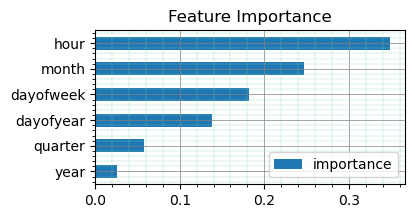

In [105]:

fi = pd.DataFrame(
    data=model.feature_importances_,
    index=model.feature_names_in_,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(4, 2))
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

In [107]:
model.feature_importances_

array([0.13809589, 0.34923965, 0.1818622 , 0.05740253, 0.24737705,
       0.02602268], dtype=float32)

### Inference

Next we are going to make some predictions based on the `train` and `test` data.

In [117]:
test['prediction'] = model.predict(X_test)
train['prediction'] = model.predict(X_train)
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,30422.880859
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53,28121.423828
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53,27169.205078
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53,26777.427734
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53,26777.427734


WE are going to start with the `train` set.

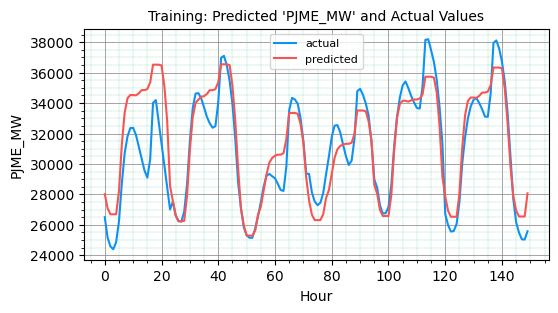

,actuals,predicted
0,26498.0,28015.039062
1,25147.0,27081.685547
2,24574.0,26689.908203
3,24393.0,26689.908203
4,24860.0,26689.908203
5,26222.0,28212.619141
6,28702.0,31256.199219
7,30698.0,33374.000000
8,31800.0,34314.648438
9,32359.0,34534.695312


In [126]:
train_true = train['PJME_MW'].to_numpy()[:150]
train_preds = train['prediction'].to_numpy()[:150]

plt.figure(figsize=(6, 3))
plt.plot(train_true, label='actual', color="#0D92F4")
plt.plot(train_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('PJME_MW', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Training: Predicted 'PJME_MW' and Actual Values", fontsize=10)
plt.show()

train_preds_dataframe = pd.DataFrame({ "actuals": train_true , "predicted": train_preds})
train_preds_dataframe.head(10)

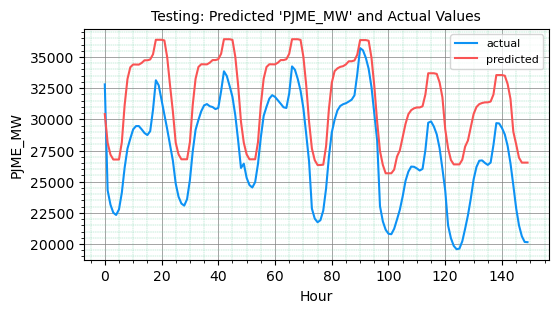

,actuals,predicted
0,32802.0,30422.880859
1,24305.0,28121.423828
2,23156.0,27169.205078
3,22514.0,26777.427734
4,22330.0,26777.427734
5,22773.0,26777.427734
6,24106.0,28151.791016
7,26129.0,31146.990234
8,27660.0,33237.468750
9,28461.0,34178.128906


In [128]:
test_true = test['PJME_MW'].to_numpy()[:150]
test_preds = test['prediction'].to_numpy()[:150]

plt.figure(figsize=(6, 3))
plt.plot(test_true, label='actual', color="#0D92F4")
plt.plot(test_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('PJME_MW', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Testing: Predicted 'PJME_MW' and Actual Values", fontsize=10)
plt.show()

train_preds_dataframe = pd.DataFrame({ "actuals": test_true , "predicted": test_preds})
train_preds_dataframe.head(10)

### `Root Mean Squared Error (RMSE)`

In [131]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


### Calculate Error
Next we are going to calculate the preddiction errors of our model.

In [134]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64

### Refs.

1. https://xgboost.readthedocs.io/en/stable/install.html#minimal-installation-cpu-only